Jeremy Green 
2/22/25

In [1]:
import os
import spacy
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from IPython.display import display
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder

Task 1: Load and Explore the Dataset
Load the dataset, explore its structure, and perform any preprocessing you find necessary.

In [2]:
# Define the path to the text file
file_path = r"C:\Users\greenjc\OneDrive - National Institutes of Health\productsentiment\Product_Sentiment.txt"

# Read the text file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter='\t', header=None)

# Rename columns using df.rename()
df = df.rename(columns={0: "text"})

# Extract the text and sentiment into separate columns
df[['text', 'sentiment']] = df['text'].str.extract(r'\("(.+)",\s*"(.+)"\)')

# Display the DataFrame
#print(df)

Task 2: Build a Traditional ML Classifier
Use any traditional ML approach, such as SVM with Bag of Words, to build a sentiment classifier and evaluate its
performance. Note: A traditional ML model requires training, so the data must be split into training and test sets.
The model needs to be built using the training data and evaluated on the test data to assess its performance.

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
# Tokenization with spaCy
df["token"] = df["text"].apply(lambda x: [token.text for token in nlp(x)])
#print(df)

# List all columns in the DataFrame
#print(df.columns)

In [5]:
# Function to remove stop words
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]  # Exclude stop words
    return tokens

# Apply the function to your DataFrame
df["excludestop"] = df["token"].apply(lambda tokens: ' '.join(tokens)).apply(remove_stopwords)

# Display the DataFrame
#print(df)

# List all columns in the DataFrame
#print(df.columns)

In [6]:
# Function to perform lemmatization on stopword-removed tokens
def lemmatize_tokens(text):
    doc = nlp(text)  # Process the text with spaCy
    lemmas = [token.lemma_ for token in doc]  # Lemmatize the tokens
    return lemmas

# Join tokens back into a string before lemmatization
df["excludestop"] = df["excludestop"].apply(lambda tokens: ' '.join(tokens))

# Apply lemmatization on tokens without stop words
df["lemmatized"] = df["excludestop"].apply(lemmatize_tokens)

# Display the DataFrame
#print(df)

# List all columns in the DataFrame
#print(df.columns)

In [7]:
# Create a new DataFrame for visualization
df_visualization = pd.DataFrame({
    "Original Tweet": df["token"].apply(lambda x: ' '.join(x)),  # Join tokens back into a string
    "Tokens": df["excludestop"].apply(lambda x: ", ".join(x)),  # Display tokens without stop words
    "Lemmatized Tokens": df["lemmatized"].apply(lambda x: ", ".join(x))  # Display lemmatized tokens
})

# Print the DataFrame
#print(df_visualization)

# Optional: Render the DataFrame as an HTML table for better visualization (e.g., in a Jupyter Notebook)
#display(df_visualization)

In [8]:
# Define features (X) and target (y)
X = df['lemmatized']
y = df['sentiment']

In [9]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
# Convert text data into Bag of Words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_test_bow = vectorizer.transform(X_test.apply(lambda x: ' '.join(x)))

In [11]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_bow, y_train)

SVC(kernel='linear')

In [12]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test_bow)

In [13]:
# Evaluate the classifier
#accuracy = accuracy_score(y_test, y_pred)
#report = classification_report(y_test, y_pred)
#
#print("Accuracy:", accuracy)
#print("Classification Report:\n", report)

In [14]:
# Create a DataFrame with y_test and y_pred
dfml = pd.DataFrame({'label': y_test, 'sentiment': y_pred})
dfml['label'] = dfml['label'].map({'positive': 1, 'negative': 0})
dfml['sentiment'] = dfml['sentiment'].map({'positive': 1, 'negative': 0})
# Display the DataFrame
#dfml

In [15]:
def evaluate_classifier(df):
    accuracy = accuracy_score(df['label'], df['sentiment'])
    report = classification_report(df['label'], df['sentiment'], zero_division=0)
    
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    
    #return accuracy, report

# Call the function with df
evaluate_classifier(dfml)

Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.33      0.50      0.40         2

    accuracy                           0.62         8
   macro avg       0.57      0.58      0.56         8
weighted avg       0.68      0.62      0.65         8



Task 3: Experiment with a Traditional NLP Approach. Use any traditional NLP technique, such as TF-IDF or word embeddings, to improve sentiment classification and compare results.

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
# Define the path to the text file
file_path = r"C:\Users\greenjc\OneDrive - National Institutes of Health\productsentiment\Product_Sentiment.txt"

# Read the text file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter='\t', header=None)

# Rename columns using df.rename()
df = df.rename(columns={0: "text"})

# Extract the text and sentiment into separate columns
df[['text', 'sentiment']] = df['text'].str.extract(r'\("(.+)",\s*"(.+)"\)')

# Display the DataFrame
#print(df)

In [18]:
# Tokenization with spaCy
df["token"] = df["text"].apply(lambda x: [token.text for token in nlp(x)])
#print(df)

# List all columns in the DataFrame
#print(df.columns)

In [19]:
# Function to remove stop words
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]  # Exclude stop words
    return tokens

# Apply the function to your DataFrame
df["excludestop"] = df["token"].apply(lambda tokens: ' '.join(tokens)).apply(remove_stopwords)

# Display the DataFrame
#print(df)

# List all columns in the DataFrame
#print(df.columns)

In [20]:
# Function to perform lemmatization on stopword-removed tokens
def lemmatize_tokens(text):
    doc = nlp(text)  # Process the text with spaCy
    lemmas = [token.lemma_ for token in doc]  # Lemmatize the tokens
    return lemmas

# Join tokens back into a string before lemmatization
df["excludestop"] = df["excludestop"].apply(lambda tokens: ' '.join(tokens))

# Apply lemmatization on tokens without stop words
df["lemmatized"] = df["excludestop"].apply(lemmatize_tokens)

# Display the DataFrame
#print(df)

# List all columns in the DataFrame
#print(df.columns)

In [21]:
# Create a new DataFrame for visualization
df_visualization = pd.DataFrame({
    "Original Tweet": df["token"].apply(lambda x: ' '.join(x)),  # Join tokens back into a string
    "Tokens": df["excludestop"].apply(lambda x: ", ".join(x)),  # Display tokens without stop words
    "Lemmatized Tokens": df["lemmatized"].apply(lambda x: ", ".join(x))  # Display lemmatized tokens
})

# Print the DataFrame
#print(df_visualization)

# Optional: Render the DataFrame as an HTML table for better visualization (e.g., in a Jupyter Notebook)
#display(df_visualization)

In [22]:
# Define features (X) and target (y)
X = df['lemmatized']
y = df['sentiment']

In [23]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# Convert text data into Bag of Words representation
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x)))
X_test_tfidf = vectorizer.transform(X_test.apply(lambda x: ' '.join(x)))

In [25]:
# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [26]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test_tfidf)

In [27]:
# Evaluate the classifier
#accuracy = accuracy_score(y_test, y_pred)
#report = classification_report(y_test, y_pred, zero_division=0)
#
#print("Accuracy:", accuracy)
#print("Classification Report:\n", report)

In [28]:
# Create a DataFrame with y_test and y_pred
dfnlp = pd.DataFrame({'label': y_test, 'sentiment': y_pred})
dfnlp['label'] = dfnlp['label'].map({'positive': 1, 'negative': 0})
dfnlp['sentiment'] = dfnlp['sentiment'].map({'positive': 1, 'negative': 0})
# Display the DataFrame
#dfnlp

In [29]:
#def evaluate_classifier(df):
#    accuracy = accuracy_score(df['label'], df['sentiment'])
#    report = classification_report(df['label'], df['sentiment'], zero_division=0)
#    
#    print("Accuracy:", accuracy)
#    print("Classification Report:\n", report)
#    
#    #return accuracy, report

# Call the function with df
evaluate_classifier(dfnlp)

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.33      0.50         3

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8



Task 4: Try a Transformer-Based Model. Use any transformer model of your choice to perform sentiment analysis and compare its performance with traditional approaches.


In [30]:
# Define the path to the text file
file_path = r"C:\Users\greenjc\OneDrive - National Institutes of Health\productsentiment\Product_Sentiment.txt"

# Read the text file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter='\t', header=None)

# Rename columns using df.rename()
df = df.rename(columns={0: "text"})

# Extract the text and sentiment into separate columns
df[['text', 'label']] = df['text'].str.extract(r'\("(.+)",\s*"(.+)"\)')

# Display the DataFrame
#print(df)

In [31]:


# Define the model name
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)



def get_binary_sentiment(text):
    # Tokenize the text and get model logits
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits

    # Apply softmax to get probabilities for each of the three classes:
    # Index 0: negative, Index 1: neutral, Index 2: positive
    probs = F.softmax(logits, dim=1).squeeze()

    # For binary classification, consider only negative and positive probabilities.
    neg_prob = probs[0].item()
    pos_prob = probs[2].item()

    # Decide based solely on negative vs positive
    sentiment = "positive" if pos_prob > neg_prob else "negative"
    # You could also return the corresponding score if desired.
    score = pos_prob if pos_prob > neg_prob else neg_prob

    return pd.Series([sentiment, score])

# Apply the function to the 'text' column and create new columns 'sentiment' and 'score'
df[['sentiment', 'score']] = df['text'].apply(get_binary_sentiment)

#print(df)


In [32]:
df['label'] = df['label'].map({'positive': 1, 'negative': 0})
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
#print(df)

In [33]:
# Evaluate the classifier
#accuracy = accuracy_score(df['label'], df['sentiment'])
#report = classification_report(df['label'], df['sentiment'], zero_division=0)
#
#print("Accuracy:", accuracy)
#print("Classification Report:\n", report)

In [34]:
# Rename the DataFrame itself
dftransformer = df

In [35]:
#dftransformer

In [36]:
#def evaluate_classifier(df):
#    accuracy = accuracy_score(df['label'], df['sentiment'])
#    report = classification_report(df['label'], df['sentiment'], zero_division=0)
#    
#    print("Accuracy:", accuracy)
#    print("Classification Report:\n", report)
#    
#    #return accuracy, report

# Call the function with df
evaluate_classifier(dftransformer)

Accuracy: 0.8108108108108109
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        23
           1       0.67      1.00      0.80        14

    accuracy                           0.81        37
   macro avg       0.83      0.85      0.81        37
weighted avg       0.87      0.81      0.81        37



Task 5: Explore Prompt Engineering. Experiment with any prompting technique and analyze how well it works for sentiment classification.


In [37]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [38]:
# Define the path to the text file
file_path = r"C:\Users\greenjc\OneDrive - National Institutes of Health\productsentiment\Product_Sentiment.txt"

# Read the text file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter='\t', header=None)

# Rename columns using df.rename()
df = df.rename(columns={0: "text"})

# Extract the text and sentiment into separate columns
df[['text', 'label']] = df['text'].str.extract(r'\("(.+)",\s*"(.+)"\)')

# Display the DataFrame
#print(df)

In [39]:
# Initialize the OpenAI model
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

C:\Users\greenjc\AppData\Local\Temp\ipykernel_22548\374060148.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)


In [40]:
# Define a prompt template for classification
prompt_template = PromptTemplate(
    input_variables=["text"],
    template="""
    You are an expert text classifier. Categorize the given text strictly into one of the following categories:
    - positive
    - negative


    Text: "{text}"

    Provide only "positive" or "negative" as output. Do not include "neutral" or any other category.
    """
)

In [41]:
# Create a chain
classification_chain = LLMChain(llm=llm, prompt=prompt_template)

C:\Users\greenjc\AppData\Local\Temp\ipykernel_22548\3655279561.py:2: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  classification_chain = LLMChain(llm=llm, prompt=prompt_template)


In [42]:
# Function to classify text
def classify_text(text):
    return classification_chain.run(text=text)

In [43]:
# Apply the function to the 'text' column and create a new column with the results
df['sentiment'] = df['text'].apply(classify_text)

C:\Users\greenjc\AppData\Local\Temp\ipykernel_22548\2815615971.py:3: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return classification_chain.run(text=text)


In [44]:
df['label'] = df['label'].map({'positive': 1, 'negative': 0})
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
#print(df)

In [45]:
dfprompt = df

In [46]:
#dfprompt

In [47]:
#def evaluate_classifier(df):
#    accuracy = accuracy_score(df['label'], df['sentiment'])
#    report = classification_report(df['label'], df['sentiment'], zero_division=0)
#    
#    print("Accuracy:", accuracy)
#    print("Classification Report:\n", report)
#    
#    #return accuracy, report

# Call the function with df
evaluate_classifier(dfprompt)

Accuracy: 0.972972972972973
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.93      1.00      0.97        14

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.97        37
weighted avg       0.97      0.97      0.97        37



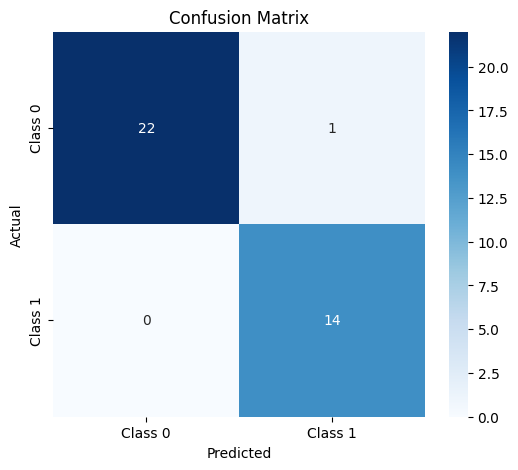

In [48]:
# Compute confusion matrix
cm = confusion_matrix(dfprompt['label'], dfprompt['sentiment'])

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
#print("Classification Report:\n", classification_report(df['label'], df['sentiment']))

Task 6: Discussion & Insights. Compare the different approaches, share your observations, and discuss your findings with peers.

Overall, I used 4 different approaches for sentiment analysis: (a) machine learning, (b) natural language processing, (c) transfomer (cardiffnlp/twitter-roberta-base-sentiment), and (d) prompt engineering (gpt-4o-mini). In this application, prompt engineering gpt-4o-mini is 97% accurate; the transformer cardiffnlp/twitter-roberta-base-sentiment is 81% accurate.   